# Simulation functions for different TF distance-dependent cooperativity modes

## Setup

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Distance vector and defaults

In [2]:
min_dist = 10
dists = np.arange(min_dist, 301)

### Viz function

In [3]:
def vis_signal(dists: np.ndarray,
               activations: np.ndarray,
               title: str,
               x_label: str="Distance (basepairs)",
               y_label: str="Activation value",
               aspect: float=1.9,
               height: float=np.nan,
               width: float=6.0,
               grid: bool=True,
               **plot_kw) -> tuple:
    if height is np.nan:
        height = width / aspect
    if width is np.nan:
        width = height * aspect
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(dists, activations, **plot_kw)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    if grid:
        ax.grid()
    return fig, ax

## Periodicity with a amplitude and activation decaying with distance 

In [4]:
def periodicity_activation(dists: np.ndarray,
                           period: float,
                           amplitude: float,
                           ampl_decay_rate,
                           y_offset: float,
                           offset_decay_rate: float,
                           x_offset: int=10) -> np.ndarray:
    """
    Generate a periodic activation signal with an amplitude and offset that decay 
    exponentially with distance.

    Parameters
    ----------
    dists : np.ndarray
        Array of distances (in basepairs) over which the activation is computed.
    period : float
        Period (in basepairs) of the sine wave representing the periodicity.
    amplitude : float
        Initial amplitude of the sine wave.
    ampl_decay_rate : float
        Exponential decay rate of the amplitude with distance.
    y_offset : float
        Initial vertical offset of the sine wave.
    offset_decay_rate : float
        Exponential decay rate of the vertical offset with distance.
    x_offset : int, optional
        Offset applied to the distances, by default 10. Normally, this is the
        distance at which the activation starts to be non-zero.

    Returns
    -------
    np.ndarray
        Array of activation values corresponding to the input distances.
    """
    offs_dists = dists - x_offset
    envelope = amplitude * np.exp(-ampl_decay_rate * offs_dists)
    offset_envelope = y_offset * np.exp(-offset_decay_rate * offs_dists)
    freq = 1 / period
    # set distances below x_offset to zero
    envelope[offs_dists < 0] = 0
    offset_envelope[offs_dists < 0] = 0
    return envelope * np.sin(2 * np.pi * freq * offs_dists) + offset_envelope


In [5]:
y_periodic = periodicity_activation(
    dists,
    period=10.4,
    amplitude=1,
    ampl_decay_rate=0.05,
    y_offset=1.5,
    offset_decay_rate=0.04,
    x_offset=min_dist)

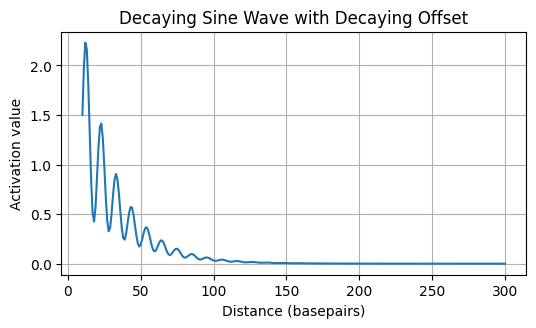

In [6]:
fig, ax = vis_signal(dists, y_periodic,
                     title="Decaying Sine Wave with Decaying Offset")

## Bowl-shaped: high value for short and for long distances, parabolic decay between

In [7]:
def bowl_activation(dists: np.ndarray,
                    y_max0: float,
                    y_max1: float,
                    bowl_depth: float,
                    bowl_width: int=None,
                    x_offset: float=10) -> np.ndarray:
    """
    Generate a bowl-shaped activation signal with high values at short and long 
    distances and a parabolic decay and rise in between.

    Parameters
    ----------
    dists : np.ndarray
        Array of distances (in basepairs) over which the activation is computed.
    y_max0 : float
        Maximum activation value at the start of the distance range.
    y_max1 : float
        Maximum activation value at the end of the distance range.
    bowl_depth : float
        Depth of the bowl, representing the minimum activation value at the center.
    bowl_width : int, optional
        Width of the bowl, representing the distance range over which the parabolic 
        decay occurs. If None, it defaults to the range of `dists` minus `x_offset`.
    x_offset : float, optional
        Offset applied to the distances, by default 10. Normally, this is the
        minimum distance in the input array.

    Returns
    -------
    np.ndarray
        Array of activation values corresponding to the input distances.
    """
    if bowl_width is None:
        bowl_width = dists[-1] - x_offset
    
    xm = (2 * x_offset + bowl_width) / 2
    ym = min(y_max0, y_max1) - abs(bowl_depth)  # The minimum y at the center (bowl bottom)

    # Fit a parabola: y = a(x - xm)^2 + ym
    # Make sure it passes through (x0, y0) and (x1, y1)
    a = (y_max0 - ym) / ((x_offset - xm) ** 2)

    return a * (dists - xm) ** 2 + ym


In [8]:
y_bowl = bowl_activation(dists, 
                         y_max0=2.5,
                         y_max1=2.5,
                         bowl_depth=2,
                         x_offset=min_dist)


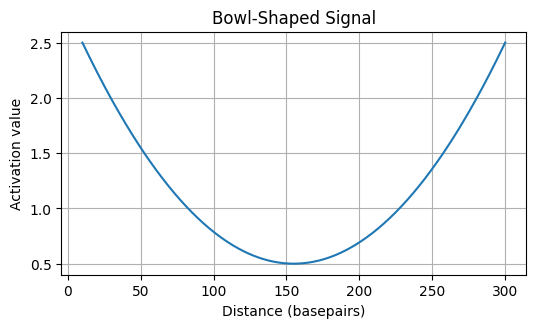

In [9]:
fig, ax = vis_signal(dists, y_bowl, title="Bowl-Shaped Signal")

## Mound-shaped: rapid rise to a peak, followed by gentle decay

In [10]:
def mound_activation(dists: np.ndarray,
                     d0: float,
                     k: float,
                     decay_rate: float, 
                     height: float,
                     x_offset: float=10) -> np.ndarray:
    """
    Generate a mound-shaped activation signal with a rapid rise to a peak 
    followed by a gentle decay.

    Parameters
    ----------
    dists : np.ndarray
        Array of distances (in basepairs) over which the activation is computed.
    d0 : float
        Distance at which the rapid rise reaches its midpoint.
    k : float
        Steepness of the sigmoid function controlling the rapid rise.
    decay_rate : float
        Exponential decay rate controlling the gentle decline after the peak.
    height : float
        Maximum height of the activation signal.
    x_offset : float, optional
        Offset applied to the distances, by default 10. Normally this is the minimum distance.

    Returns
    -------
    np.ndarray
        Array of activation values corresponding to the input distances.
    """
    sigmoid = 1 / (1 + np.exp(-k * (dists - d0)))
    decay = np.exp(-decay_rate * (dists-x_offset))
    return height * sigmoid * decay


In [11]:
y_mound = mound_activation(dists,
                           d0=40,
                           k=0.2,
                           decay_rate=0.002,
                           height=2.5,
                           x_offset=min_dist)


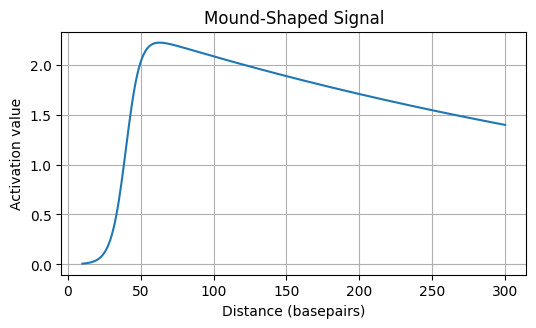

In [12]:
fig, ax = vis_signal(dists, y_mound, title="Mound-Shaped Signal")